In [142]:
import numpy as np
import pandas as pd
import scipy.io
from scipy import stats

# import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm
import os
# import pickle

# Func & Load

In [146]:
def load_metadata(root_path, paradigm_setting, session_num):
    meta = pd.read_excel(root_path + 'adp_dataset_master.xlsx', index_col=None)
    meta = meta[meta.paradigm == paradigm_setting].reset_index()
    meta = meta[['mouse','date','area','num']]

    meta.mouse = meta.mouse.astype(int)
    
    if isinstance(session_num, int):
        meta.date = meta.date.astype(int).astype(str) + '_00' + meta.num.astype(int).astype(str) + '_caiman'
        meta.num = meta.num.astype(int)
        meta = meta.loc[meta['num'] == session_num].reset_index()
    elif session_num == '':
        meta.date = meta.date.astype(int).astype(str) + '_caiman'
        # meta = meta.head(1) # multisession, only keep one metadata
    return meta

In [149]:
# root_path = r'C:\Users\GlickfeldLab\Documents\test\inter/'.replace('\\', '/')
root_path = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter/'.replace('\\', '/')
meta = load_metadata(root_path, paradigm_setting='bunnytop high res', session_num='')
print(meta)

meta = meta.iloc[0].to_frame().T.reset_index()
meta

   mouse           date area  num
0   1350  220225_caiman   V1  2.0
1   1350  220225_caiman   V1  3.0
2   1369  220310_caiman   V1  2.0
3   1369  220310_caiman   V1  3.0


,index,mouse,date,area,num
0,0,1350,220225_caiman,V1,2.0


In [155]:
# root_path = 'C:/Users/ll357/Documents/inter/'
# meta = load_metadata(root_path, paradigm_setting='bunnytop', session_num='')
# print(meta)

dir_name = root_path # + 'mat/' # no need for mat folder
iset = 0
dir_sub = str(meta.area[iset]) + '_i' + str(meta.mouse[iset]) + '_' + str(meta.date[iset])

dfof_trialwise = scipy.io.loadmat(os.path.join(dir_name, dir_sub[:-7], 'resp_base_trialwise' + '.mat')) # delete caiman in dir_sub
print(dfof_trialwise['dfof_ad_trial'].shape, dfof_trialwise['dfof_ad_trial'][0,0].shape)

dfof_ad_trial = dfof_trialwise['dfof_ad_trial'] # do not subtract baseline here: stim resp will be compared to base resp
dfof_tg_trial = dfof_trialwise['dfof_tg_trial']

(71, 30) (19, 1)


# One way anova
for each cell, base = [ntrial, 1], stim_resp = [ntrial_stim, nstim].  
base vs stim anova or kruskal wallis

In [156]:
ncell = dfof_ad_trial.shape[0]
nstim = dfof_ad_trial.shape[1]

p_anova = np.ones((ncell, 1)) * np.nan
p_kruskal = np.ones((ncell, 1)) * np.nan
# p_alexandergovern = np.ones((ncell, 1)) * np.nan

for icell in tqdm(np.arange(ncell)):
    base_cell = np.concatenate([dfof_trialwise['dfof_base_trial'][icell, stim] for stim in range(nstim)])
    stim_cell = [] 
    for istim in np.arange(nstim):
        stim_cell.append(np.array(dfof_ad_trial[icell, istim]).flatten())
    
    _, p_anova_cell = stats.f_oneway(np.array(base_cell).flatten(), *stim_cell)
    p_anova[icell] = p_anova_cell
    _, p_kruskal_cell = stats.kruskal(np.array(base_cell).flatten(), *stim_cell)
    p_kruskal[icell] = p_kruskal_cell
    # _, p_alexandergovern_cell = stats.alexandergovern(np.array(base_cell).flatten(), *stim_cell)
    # p_alexandergovern[icell] = p_alexandergovern_cell
    # print(stats.alexandergovern(np.array(base_cell).flatten(), *stim_cell)) # alexandergovern result cannot extract p-value

100%|██████████| 71/71 [00:00<00:00, 457.95it/s]


(array([39]), array([37]))

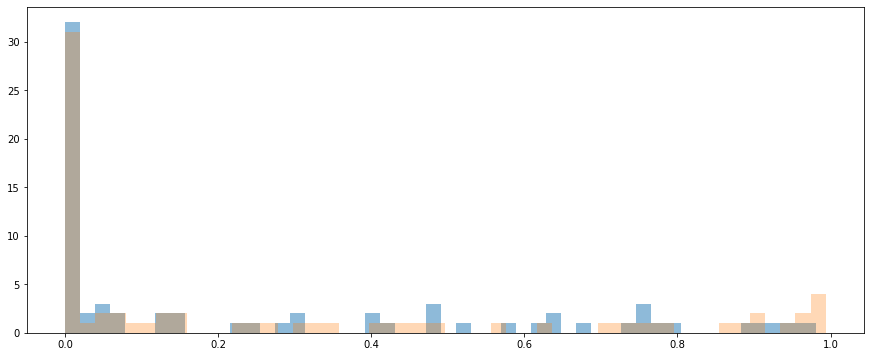

In [157]:
plt.figure(figsize=(15,6))
plt.hist(p_anova, 50, alpha=0.5);
plt.hist(p_kruskal, 50, alpha=0.3);
sum(p_anova < 0.1), sum(p_kruskal < 0.1)

# One sided t test
for each cell, base = [ntrial_stim, 1], stim_resp = [ntrial_stim, nstim].  
base vs stim : 1 sided t test

In [158]:
p_ttest = np.ones((ncell, nstim)) * np.nan

for icell in tqdm(np.arange(ncell)):
    for istim in np.arange(nstim):
        base_cell = dfof_trialwise['dfof_base_trial'][icell, istim]
        stim_cell = dfof_trialwise['dfof_ad_trial'][icell, istim]
        
        _, p_ttest_i = stats.ttest_ind(base_cell.flatten(), stim_cell.flatten(), equal_var=False, alternative='less')
        p_ttest[icell, istim] = p_ttest_i

100%|██████████| 71/71 [00:00<00:00, 142.96it/s]


In [159]:
print(0.05*ncell)
sum(p_ttest < 0.05)#.mean()

3.5500000000000003


array([ 0, 13,  4,  2,  5, 17,  9, 21, 12,  0,  4,  2,  8,  2, 19, 18,  9,
       10, 17, 15,  2, 17,  5,  6,  1,  4,  6, 13,  2,  2])

In [160]:
# sum(p_ttest.T < 0.05)
(sum(p_ttest.T < 0.05) > 0).sum()

39

# Amp thresh
trial averaged stim resp > 10%

In [161]:
evoked = np.ones((ncell, nstim)) * np.nan

for icell in tqdm(np.arange(ncell)):
    for istim in np.arange(nstim):
        base_cell = dfof_trialwise['dfof_base_trial'][icell, istim]
        stim_cell = dfof_trialwise['dfof_ad_trial'][icell, istim]
        
        evoked_cell = (stim_cell - base_cell) / (base_cell + 1e-7)
        evoked_i = np.mean(evoked_cell, axis=0) # trial averaged evoked resp
        evoked[icell, istim] = evoked_i

100%|██████████| 71/71 [00:00<00:00, 1867.97it/s]


In [162]:
evoked.shape, sum(evoked > 0.1), sum(evoked > 0.1).mean(), (sum(evoked.T > 0.1) > 0).sum()

((71, 30),
 array([0, 1, 1, 1, 1, 4, 2, 7, 1, 1, 2, 1, 1, 0, 7, 7, 2, 2, 4, 4, 0, 4,
        1, 3, 0, 3, 1, 8, 1, 1]),
 2.3666666666666667,
 12)

# AND gate
according to Ohki 2020  
anova -> visually driven cells,  
t test -> certain image responsive cells,  
amp thresh -> lower false positive rate

In [164]:
# small_values = [1,1,1,2]
# large_values = [100,100,100,100,100]

# stats.ttest_ind(small_values, large_values, equal_var=False, alternative='less')

Ttest_indResult(statistic=-395.0, pvalue=1.7891198862498212e-08)

In [165]:
ncell = dfof_ad_trial.shape[0]
nstim = dfof_ad_trial.shape[1]

p_anova = np.ones((ncell, 1)) * np.nan
p_kruskal = np.ones((ncell, 1)) * np.nan
p_ttest = np.ones((ncell, nstim)) * np.nan
evoked = np.ones((ncell, nstim)) * np.nan

for icell in tqdm(np.arange(ncell)):
    base_cell_anova = np.concatenate([dfof_trialwise['dfof_base_trial'][icell, stim] for stim in range(nstim)])
    stim_cell_anova = [] 
    for istim in np.arange(nstim):
        stim_cell_anova.append(np.array(dfof_ad_trial[icell, istim]).flatten())

        base_cell = dfof_trialwise['dfof_base_trial'][icell, istim]
        stim_cell = dfof_trialwise['dfof_ad_trial'][icell, istim]
        _, p_ttest_i = stats.ttest_ind(base_cell.flatten(), stim_cell.flatten(), equal_var=False, alternative='less')
        p_ttest[icell, istim] = p_ttest_i

        evoked_cell = (stim_cell - base_cell) / (base_cell + 1e-7)
        evoked_i = np.mean(evoked_cell, axis=0) # trial averaged evoked resp
        evoked[icell, istim] = evoked_i
    
    _, p_anova_cell = stats.f_oneway(np.array(base_cell_anova).flatten(), *stim_cell_anova)
    p_anova[icell] = p_anova_cell
    _, p_kruskal_cell = stats.kruskal(np.array(base_cell_anova).flatten(), *stim_cell_anova)
    p_kruskal[icell] = p_kruskal_cell

100%|██████████| 71/71 [00:00<00:00, 105.32it/s]


In [168]:
# visually driven cells: pass (anova OR kruskal) AND amp threshold for >=1 image
p_sig = 0.05
vis_driven = ((p_anova < p_sig) | (p_kruskal < p_sig)) & (sum(evoked.T > 0.1) > 0).reshape(-1, 1)
print(f'{vis_driven.sum()} cells are visually driven, \n\
    proportion {np.round(vis_driven.sum()/ncell, 2)} out of {ncell} cells')

# cells responsive to image i: pass visually driven (anova OR kruskal) AND t-test AND amp threshold for *this* image
img_driven = vis_driven & (p_ttest < p_sig) & (evoked > 0.1)
print(f'{img_driven.sum()} cells are image driven - with overlap between images, \n\
    proportion {np.round(img_driven.sum() / (ncell*nstim), 2)} out of {ncell*nstim} cell-stim combos. \n\
    1-30 image evokes resp from {np.sum(img_driven, axis=0)} cells')

t = np.sum(img_driven, axis=1)
print(f'img driven cells are driven by {t[t>0]} images')

11 cells are visually driven, 
    proportion 0.15 out of 71 cells
48 cells are image driven - with overlap between images, 
    proportion 0.02 out of 2130 cell-stim combos. 
    1-30 image evokes resp from [0 0 0 0 0 2 2 5 1 0 0 0 1 0 7 6 2 1 4 4 0 3 0 2 0 2 1 5 0 0] cells
img driven cells are driven by [ 2  1  4  3 10 10  3 11  2  1  1] images


# Trace of vis cell

In [172]:
dir_sub = 'V1_i1350_211222_caiman'
ncell = 324
dir_data = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter'.replace('\\', '/')
trace = scipy.io.loadmat(os.path.join(dir_data, dir_sub, 'trace_aligned' + '.mat')) # delete '_caiman'

In [180]:
dir_data = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter'.replace('\\', '/')
dir_sub = str(meta.area[iset]) + '_i' + str(meta.mouse[iset]) + '_' + str(meta.date[iset])
print(dir_sub)
ncell = 71
trace = scipy.io.loadmat(os.path.join(dir_data, dir_sub[:-7], 'trace_aligned' + '.mat')) # delete '_caiman'

trace_vis = []
for icell in np.arange(ncell):
    trace_cell = trace['trace_avg'][icell]
    # if vis_driven[icell]:
    trace_vis.append(trace_cell)
trace_vis = np.array(trace_vis)
print(trace_vis.shape)
# assert trace_vis.shape[0] == vis_driven.sum()

# compare btw stim
trace_mean = np.mean(trace_vis, axis=0)
trace_std = np.std(trace_vis, axis=0)
trace_sem = trace_std / np.sqrt(trace_vis.shape[0])
trace_mean.shape

V1_i1350_220225_caiman
(71, 30, 143)


(30, 143)

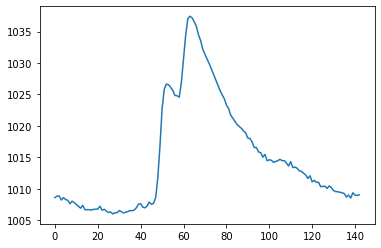

In [179]:
trace_mean_all = np.mean(np.mean(trace_vis, axis=0), axis=0)
trace_end = trace_mean_all[100:]
trace_start = trace_mean_all[:100]
trace_reform = np.concatenate([trace_end, trace_start])
plt.plot(trace_reform)
# plt.axvline(x=0, color='grey')
# plt.axvline(x=11, color='grey')
# plt.xlim([-2, 60]);

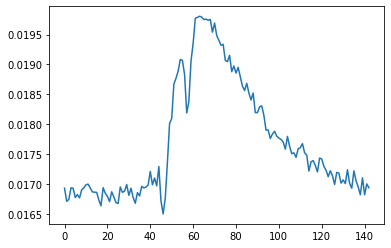

In [175]:
trace_mean_all = np.mean(np.mean(trace_vis, axis=0), axis=0)
trace_end = trace_mean_all[100:]
trace_start = trace_mean_all[:100]
trace_reform = np.concatenate([trace_end, trace_start])
plt.plot(trace_reform)
# plt.axvline(x=0, color='grey')
# plt.axvline(x=11, color='grey')
# plt.xlim([-2, 60]);

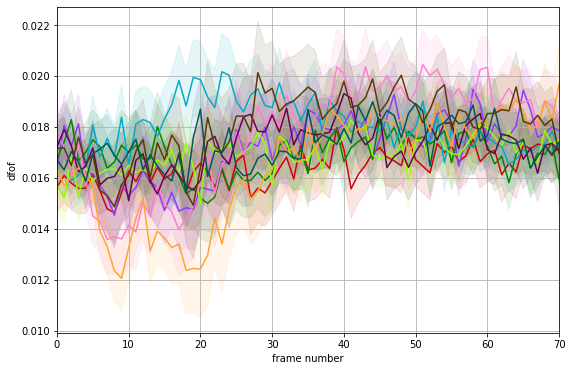

In [108]:
import seaborn as sns
import colorcet as cc

fig, ax = plt.subplots(figsize=(9,6))
long_palette = sns.color_palette(cc.glasbey, n_colors=30)
for istim in np.arange(0, 10):
    ax.plot(np.arange(trace_mean.shape[-1]), trace_mean[istim,:].flatten(), 
            color=long_palette[istim])
    
    ax.fill_between(np.arange(trace_mean.shape[-1]), 
                    trace_mean[istim,:].flatten() + trace_sem[istim,:].flatten(), 
                    trace_mean[istim,:].flatten() - trace_sem[istim,:].flatten(),
                    color=long_palette[istim], alpha=0.1)
plt.grid('minor')
plt.xlim(0,70)
plt.xlabel('frame number')
plt.ylabel('dfof')
# plt.legend(['inf', '750', '250'])
plt.show()

In [248]:
# print(os.getcwd())
# with open('vis_img_driven_test_sig.pickle', 'wb') as handle:
#     pickle.dump(p_anova, handle, protocol=pickle.HIGHEST_PROTOCOL)
#     pickle.dump(p_kruskal, handle, protocol=pickle.HIGHEST_PROTOCOL)
#     pickle.dump(evoked, handle, protocol=pickle.HIGHEST_PROTOCOL)
#     pickle.dump(p_ttest, handle, protocol=pickle.HIGHEST_PROTOCOL)


c:\Users\ll357\Documents\inter\code\py_playground
